Phys474 - Spring 2023

Lab 3 - The Time Dependent Schrodinger Equation 

<font color='red'>Author: 

In this lab you will gain practice in calculating the TDSE for various potentials. In particular we will examine the scattering of a guassian wave packet from 
- Step Potential
- Barrier Potential

The Schrodinger equation is given by

$i\hbar\frac{\partial\Psi(x)}{\partial x} = \hat{H}\Psi(x)$ 

or,

$i\hbar\frac{\partial\Psi(x)}{\partial x} = -\frac{\hbar^2}{2m}\nabla^2\Psi(x)+V(x)\Psi(x)$ 

We implement this in 1D using the Hamiltonian as we did for the TISE

the QM Hamiltonian is given by

$\hat{H}=T+V=-\frac{\hbar^2}{2m}\nabla^2+V$

The Laplacian $\nabla^2$ in 1D is given by an $nxn$ matrix

$\nabla^2= \frac{\partial^2}{\partial x^2}=
\frac{1}{a^2}\begin{pmatrix}
-2& 1 & 0& 0&0&\ldots \\
1 &-2 & 1 &0 &0 &\ldots\\
0 & 1 & -2& 1 & 0 & \ldots \\
0 & 0 &1&-2&1&\ldots \\
\vdots&\vdots&\vdots&\vdots&\vdots&\ddots
\end{pmatrix}$

where we put the problem on a grid of $n$ points in $x$ with spacing $a$.


Then for the Hamiltonian we have

$\hat{H}=T+V=-\frac{\hbar^2}{2m}\nabla^2+V = \frac{-\hbar^2}{2ma^2}\begin{pmatrix}
-2& 1 & 0& 0&0&\ldots \\
1 &-2 & 1 &0 &0 &\ldots\\
0 & 1 & -2& 1 & 0 & \ldots \\
0 & 0 &1&-2&1&\ldots \\
\vdots&\vdots&\vdots&\vdots&\vdots&\ddots
\end{pmatrix}  + 
\begin{pmatrix}
V(x_1)& 0 & 0& 0&0&\ldots \\
0 &V(x_2) & 0 &0 &0 &\ldots\\
0 & 0 & V(x_3)& 0 & 0 & \ldots \\
0 & 0 &0&V(x_4)&0&\ldots \\
\vdots&\vdots&\vdots&\vdots&\vdots&\ddots
\end{pmatrix} 
$

<br><br>
    
We will be examining the "motion" of an initial wavefunction $\psi(x,0)$ given as a gaussian wave packet, which are very often used
as a way to represent a "particle" of mean wavenumber (i.e. momentum) $k_0$. 

A Gaussian wave packet properly normalized such that 

$\int_{-\infty}^{\infty} \left|\psi(x,0)\right|^2  dx =1 $

is then given by

$\psi(x,0) = \frac{1}{\sqrt{\sigma_x\sqrt{2\pi}}}e^{-\frac{(x-x_0)^2}{4\sigma_x^2}}e^{ik_0x}$

where $x_0$ is the central position and $\sigma_x$ is the "spatial width" of $\left|\psi(x,0)\right|^2$ and $k_0$ is the mean wave number (i.e moving to the right with mean $k_0$).


___________________________________________________________________________________
Use the following unless instructed otherwise

- Use atomic units $\hbar =1$, use $m=m_e=1$
- use an array for $x$ with spacing $.01$ and $0\le x \le 50.$
- use an array for times with spacing $0.005$ and $0\le t \le 4$
- for the wave packet use $x_0=12.5$ and $\sigma_x=1$ unless directed otherwise
- Make your plots and animations like the example from lecture on Lab 2 with $V(x)$, $\left<E\right>$ with band of $\pm 2\sigma_E$, $|\Psi(x)|^2$

+++++++++++++++++++++++++++++++++++++++++++<br>
For the Step Potential use

$V(x)=0$ for $0\le x\le 25$ <br>
$V(x)=40$ for $25\lt x\le 50 $<br>
+++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++++++++<br>
For the Barrier Potential use 


$V(x)=V_0$ for $25\lt x\le 25+W$ <br>
$V(x)=0$ otherwise <br>

where $W$ is the width in a.u. and $V_0$ is the barrier potential, which can also be negative. Both will be 
specified below for various cases<br>
+++++++++++++++++++++++++++++++++++++++++++



In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.integrate import solve_ivp
from scipy import sparse
%matplotlib notebook 

hbar=1
m=1
x0=12.5
xmin=0
xmax=50
σₓ=1 
dx=.01
t0=0.0
tf=4.0
dt=.005
N=int((50.0-0.0)/dx)
NT=int((tf-t0)/dt)
x=np.linspace(0.0,50.0,N)
t=np.linspace(t0,tf,NT)

# laplacian= (np.diag(-2.0*np.ones(N))+np.diag(np.ones(N-1),1)+ \
#     np.diag(np.ones(N-1),-1))/dx**2

def packet(σ,x,x0,k):
    A=1/(σ*(2*np.pi)**(1/2))**(1/2)
    return A*np.exp(-(x-x0)**2/(4*σ**2))*np.exp(1j*k*x)

def energy_parameters(k0,sigma):
    sig_x=sigma
    energy=hbar**2*(k0**2/(2*m))
    kx_sigma=1/(2*sig_x)
    energy_sigma=hbar**2*k0*kx_sigma/m
    e_ul=energy+2*energy_sigma
    e_ll=energy-2*energy_sigma
    return energy,e_ul,e_ll,energy_sigma
   
def step(N,ϕ0):
    ϕ_step=np.zeros((N,N))
    for i in range(N//2-1,N):
        ϕ_step[i,i]=ϕ0
    return ϕ_step

def barrier(N,ϕ0,x,dx,width):
    ϕ_barrier=np.zeros((N,N))
    dx=(x[N//2]+width-x[N//2])//dx
    for i in range(N//2,int(N//2+dx)):
        ϕ_barrier[i,i]=ϕ0
    return ϕ_barrier

________________________________________________________________________________
Part 1 (5 points)


- make a single plot with 2 subplots top: the $Re(\Psi(x))$, $Im(\Psi(x))$ and $|\Psi(x)|$ for $k_0=5$ and $\sigma_x=1.0$, bottom:  the Fourier Transform from $x$ space to $k$ space $|f(k)|=|FFT(\Psi(x))|$
- make a single plot with 2 subplots top: the $Re(\Psi(x))$, $Im(\Psi(x))$ and $|\Psi(x)|$ for $k_0=5$ and $\sigma_x=.5$, bottom:  the Fourier Transform from $x$ space to $k$ space $|f(k)|=|FFT(\Psi(x))|$
- make a single plot with 2 subplots top: the $Re(\Psi(x))$, $Im(\Psi(x))$ and $|\Psi(x)|$ for $k_0=9$ and $\sigma_x=1.0$, bottom:  the Fourier Transform from $x$ space to $k$ space $|f(k)|=|FFT(\Psi(x))|$

Note: when you do the fft on $\Psi(x)$ you are transforming to $1/x$ space to represent the result as $f(k)$ vs $k$ you have to multiply the $1/x$=axis number by $2\pi$ to get it in $k$ space
___________________________________________________________________________________

<IPython.core.display.Javascript object>


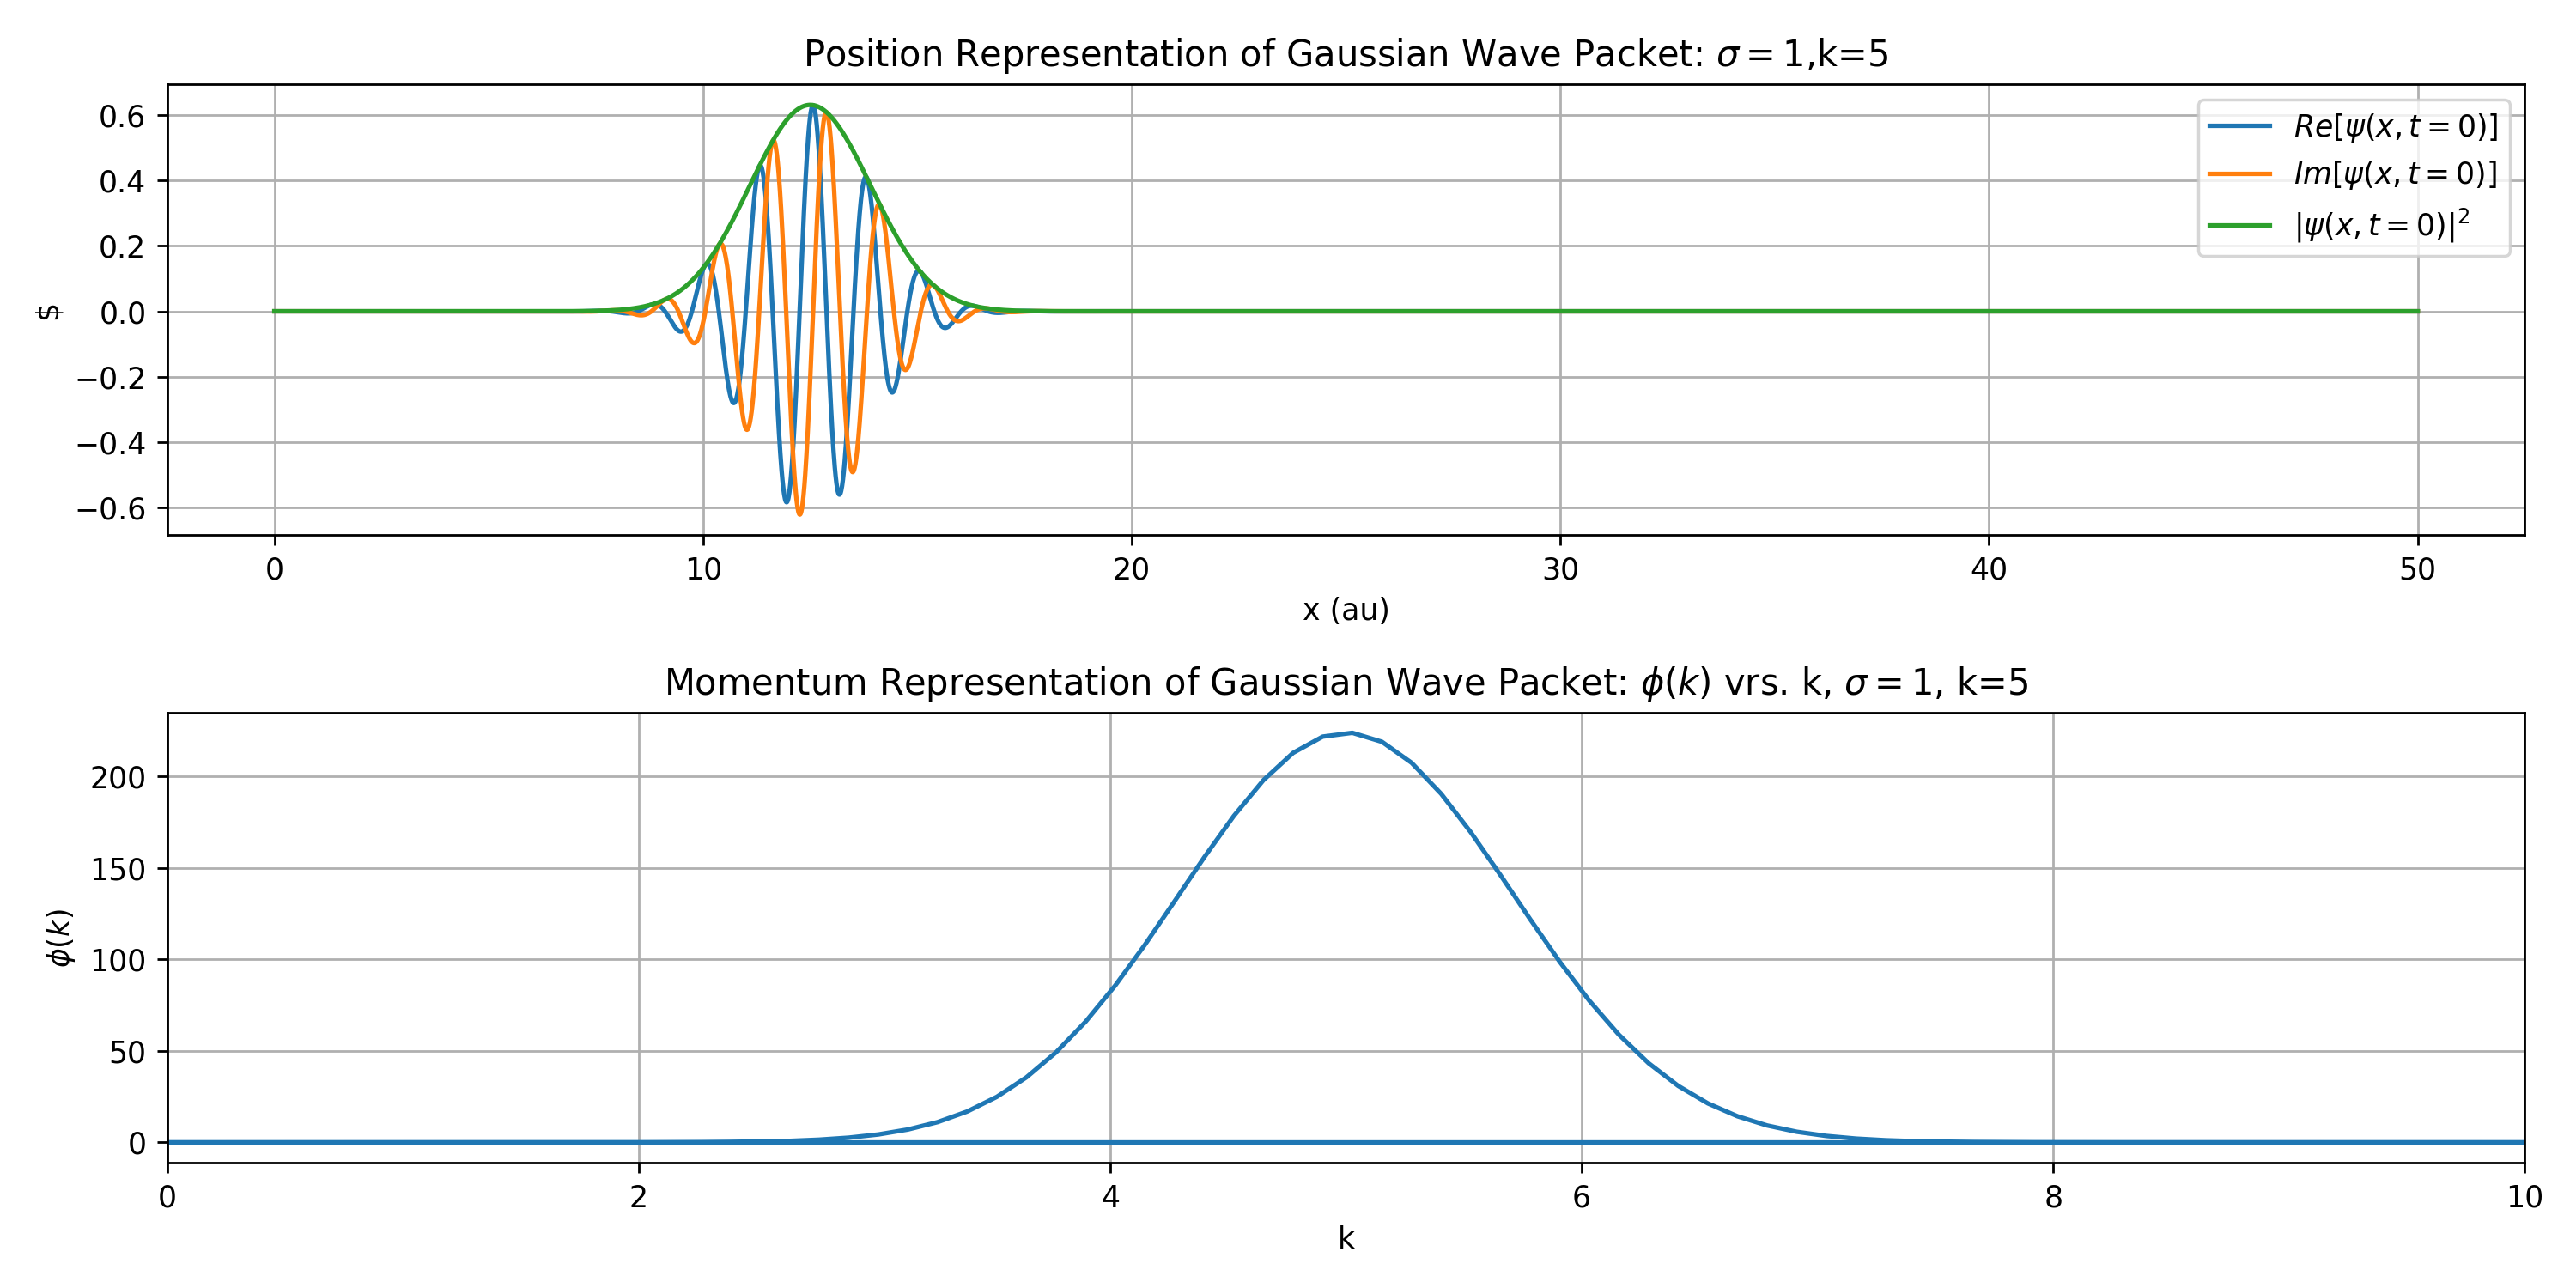

<IPython.core.display.Javascript object>


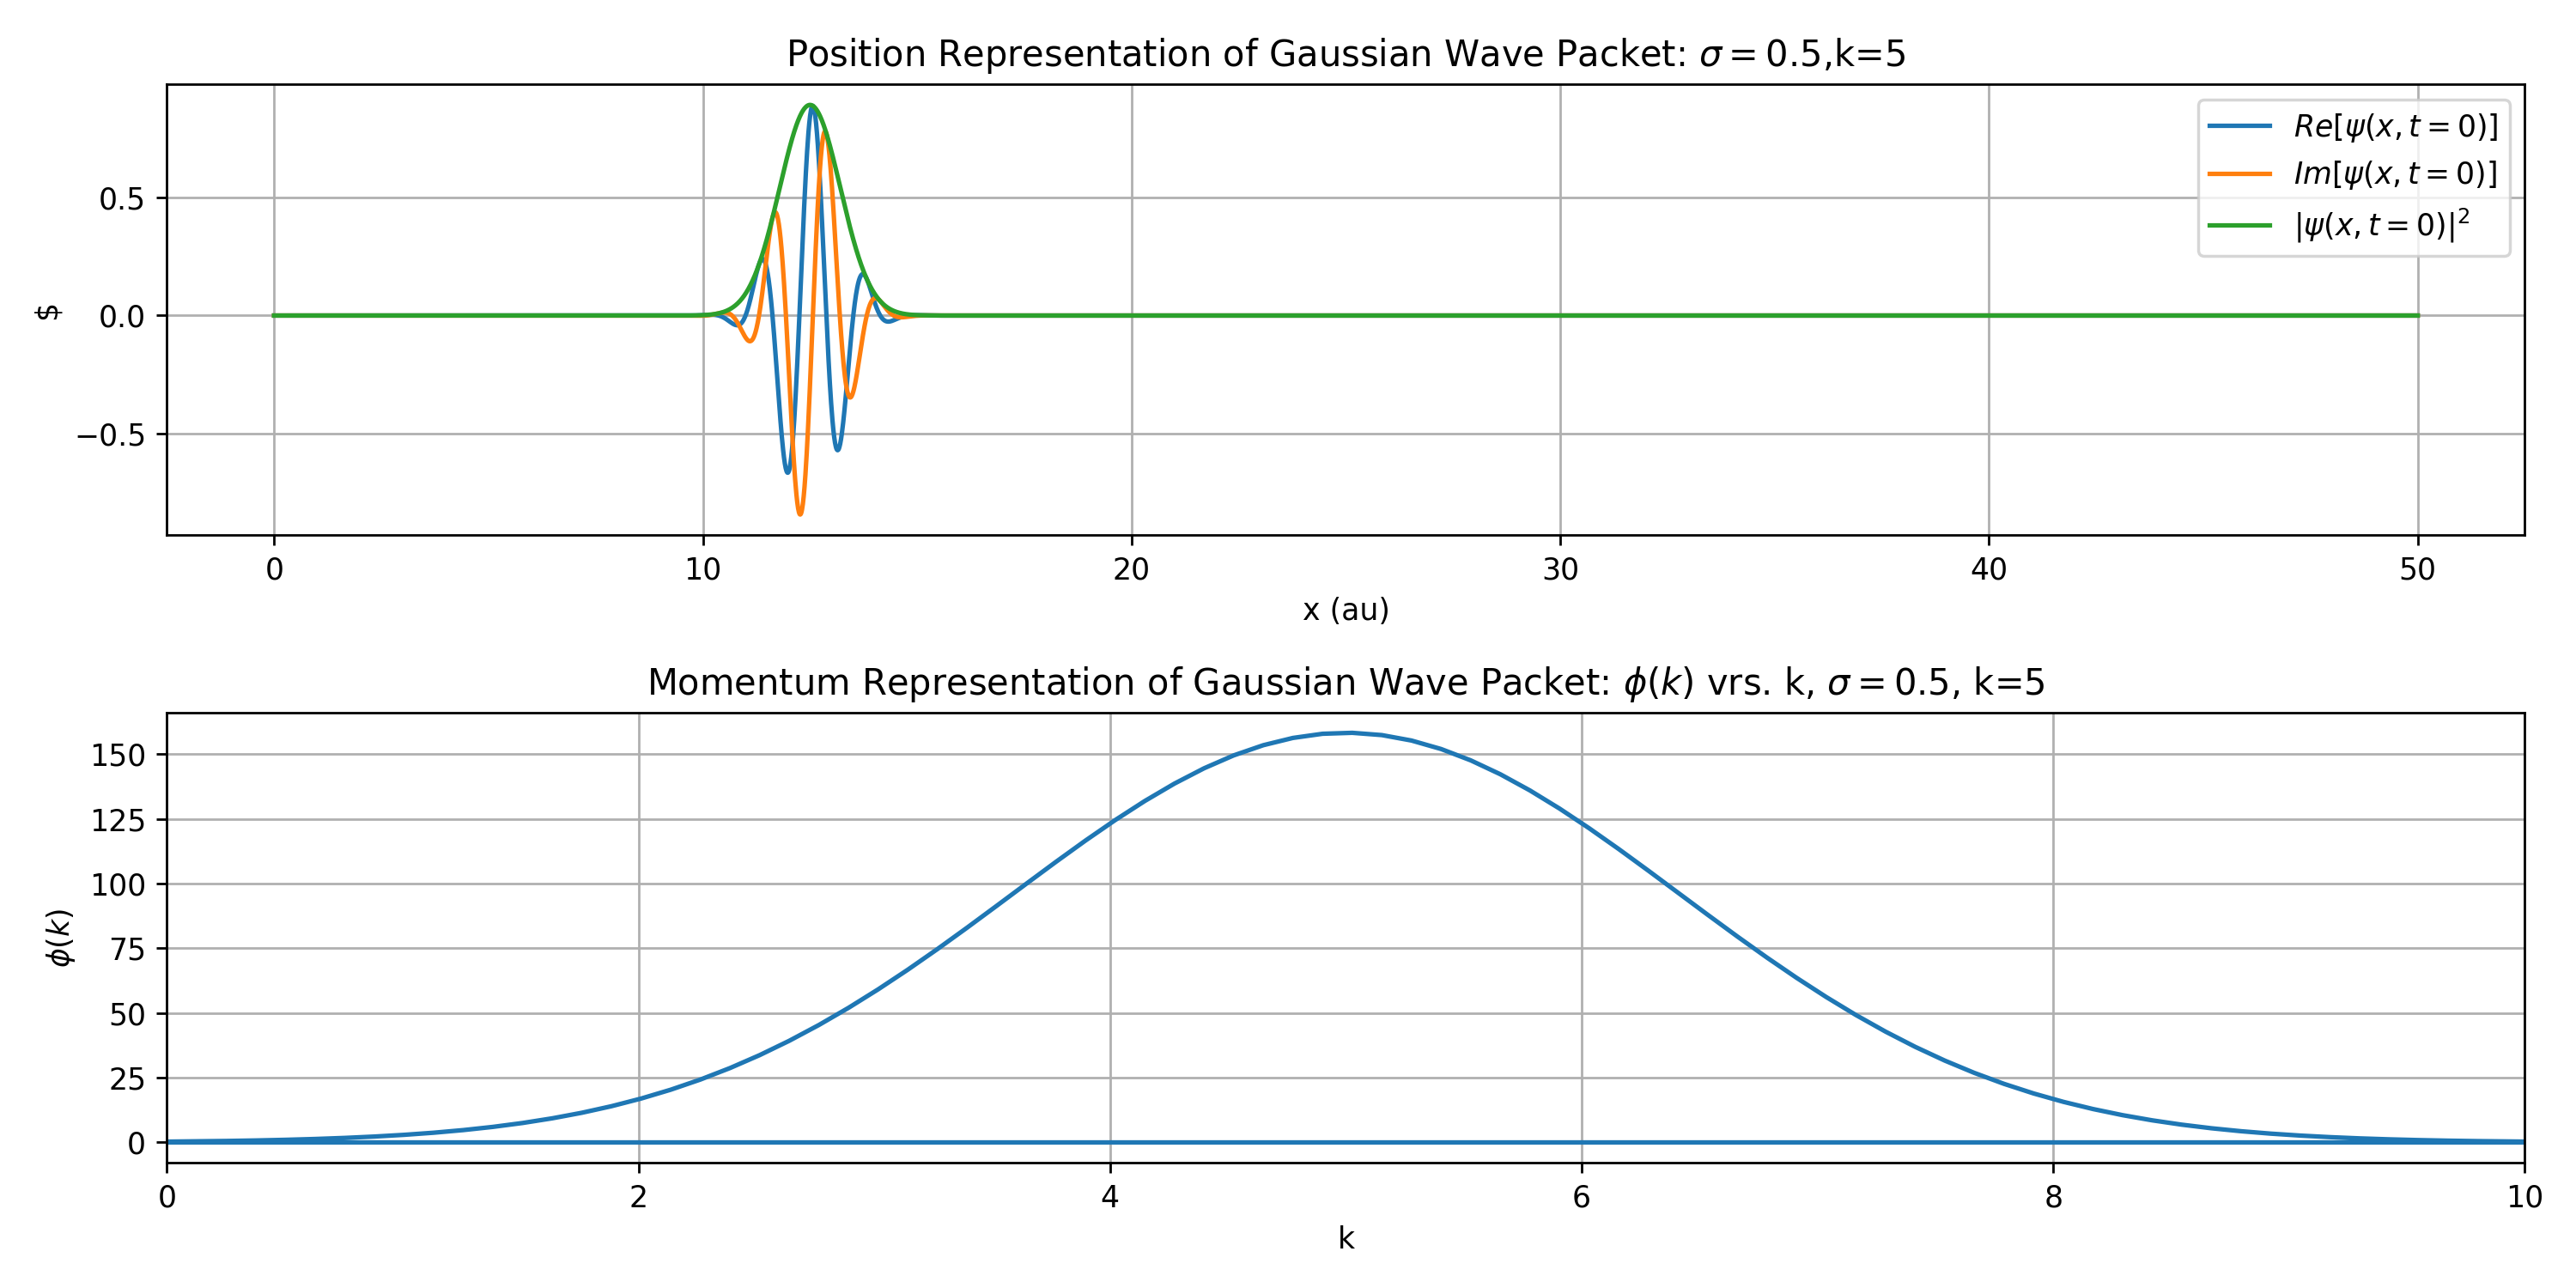

<IPython.core.display.Javascript object>


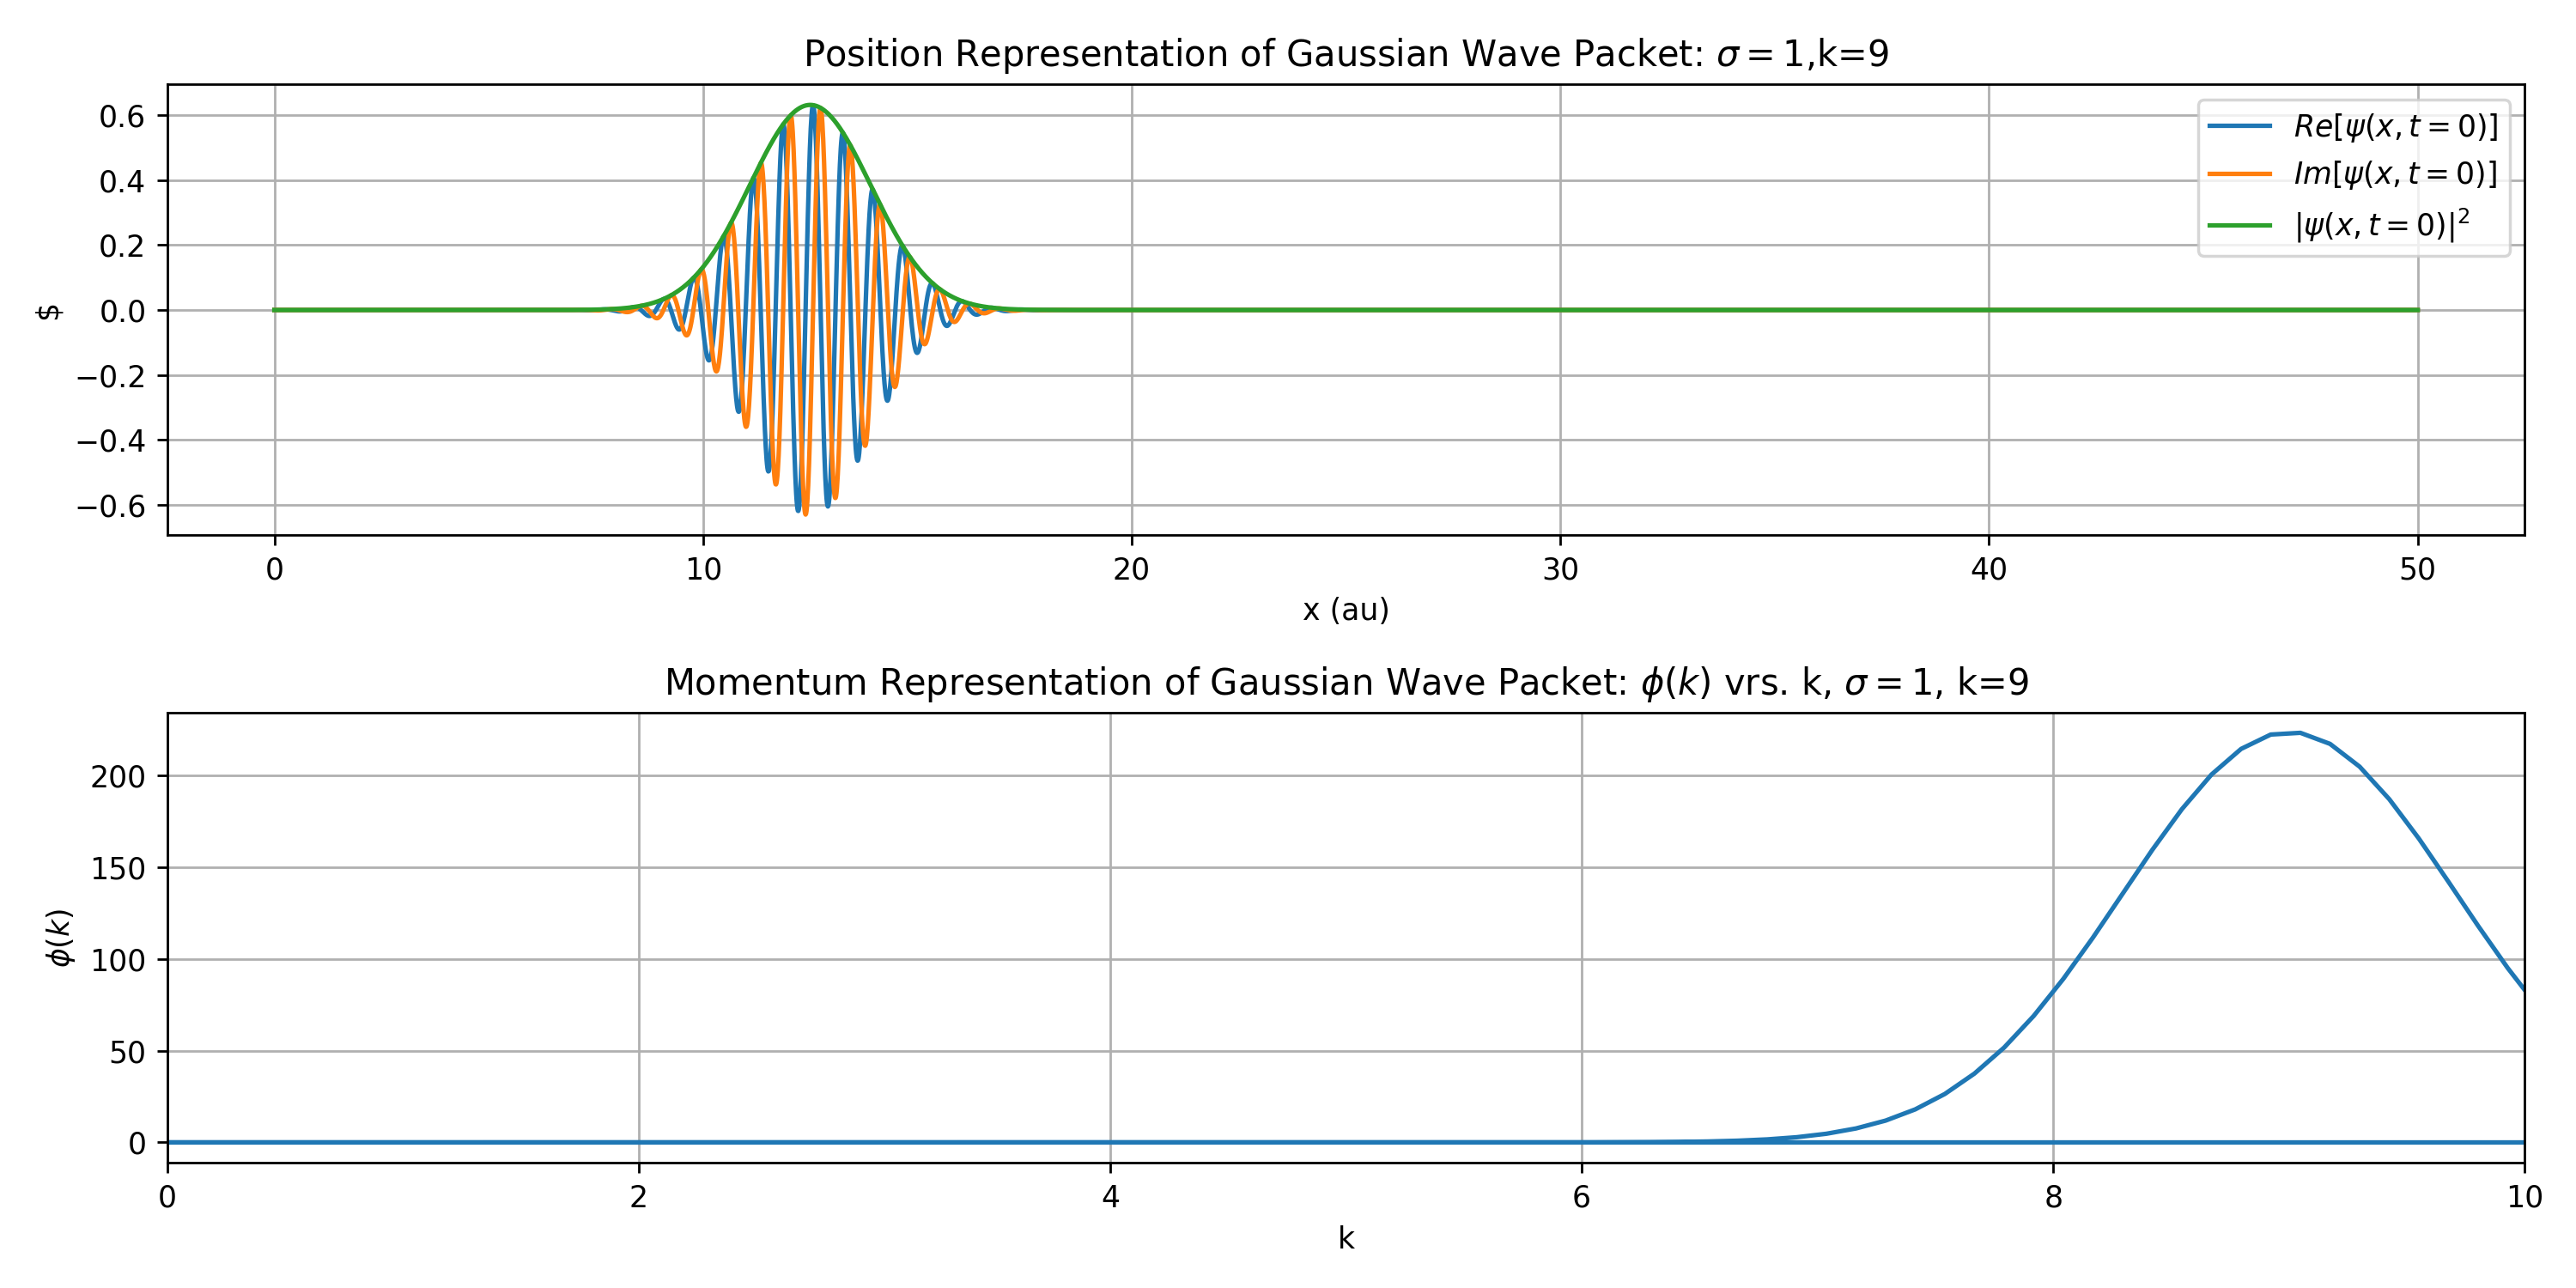

In [2]:
experiment=[(5,1),(5,.5),(9,1)]

for (k,sigma) in experiment:
    ψ=packet(sigma,x,x0,k)
    fig, ax1 = plt.subplots(2,1,figsize=(12,6))
    ax1[0].plot(x,ψ.real,label=r"$Re[\psi(x,t=0)]$")
    ax1[0].plot(x,ψ.imag,label=r"$Im[\psi(x,t=0)]$")
    ax1[0].plot(x,abs(ψ),label=r"$|\psi(x,t=0)|^2$")

    ax1[0].grid('--')
    ax1[0].set_title(r"Position Representation of Gaussian Wave Packet: $\sigma=$"+f"{sigma},k={k}")
    ax1[0].set_xlabel("x (au)")
    ax1[0].set_ylabel(r"$")
    ax1[0].legend()

    freq=np.fft.fftfreq(x.size,dx)
    spectrum=np.fft.fft(ψ)
    ax1[1].plot(2*np.pi*freq,np.abs(spectrum))
    ax1[1].grid('--')
    ax1[1].set_title(r"Momentum Representation of Gaussian Wave Packet: $\phi(k)$ vrs. k, $\sigma=$" + f"{sigma}, k={k}")
    ax1[1].set_xlabel("k")
    ax1[1].set_ylabel(r"$\phi(k)$")
    ax1[1].set_xlim((0,10))

    plt.tight_layout()
plt.show()

## _____________________________________________________________________________________
Part 2: (7 points)

In this part we will make a plot with for each of the various initial conditions

- Each case should be a figure with 3 subplots (1 for each $k_0$)
- on each subplot plot the potential, the mean energy $E_{mean}$ with a band showing the $\pm 2\sigma_E$
- The initial wavefunction squared $|\psi(x,0)|^2$ on the line for $E_{mean}$

a) Step Potential, $V_0=40$
- $k_0=7$
- $k_0=9$
- $k_0=10$

b) Barrier Potential $W=.25$, $V_0=40$
- $k_0=7$
- $k_0=9$
- $k_0=10$

c) Barrier Potential $W=1$, $V_0=40$
- $k_0=7$
- $k_0=9$
- $k_0=10$

d) Barrier Potential $W=.25$, $V_0=-20$
- $k_0=7$
- $k_0=9$
- $k_0=10$


____________________________________________________________________________________

<IPython.core.display.Javascript object>


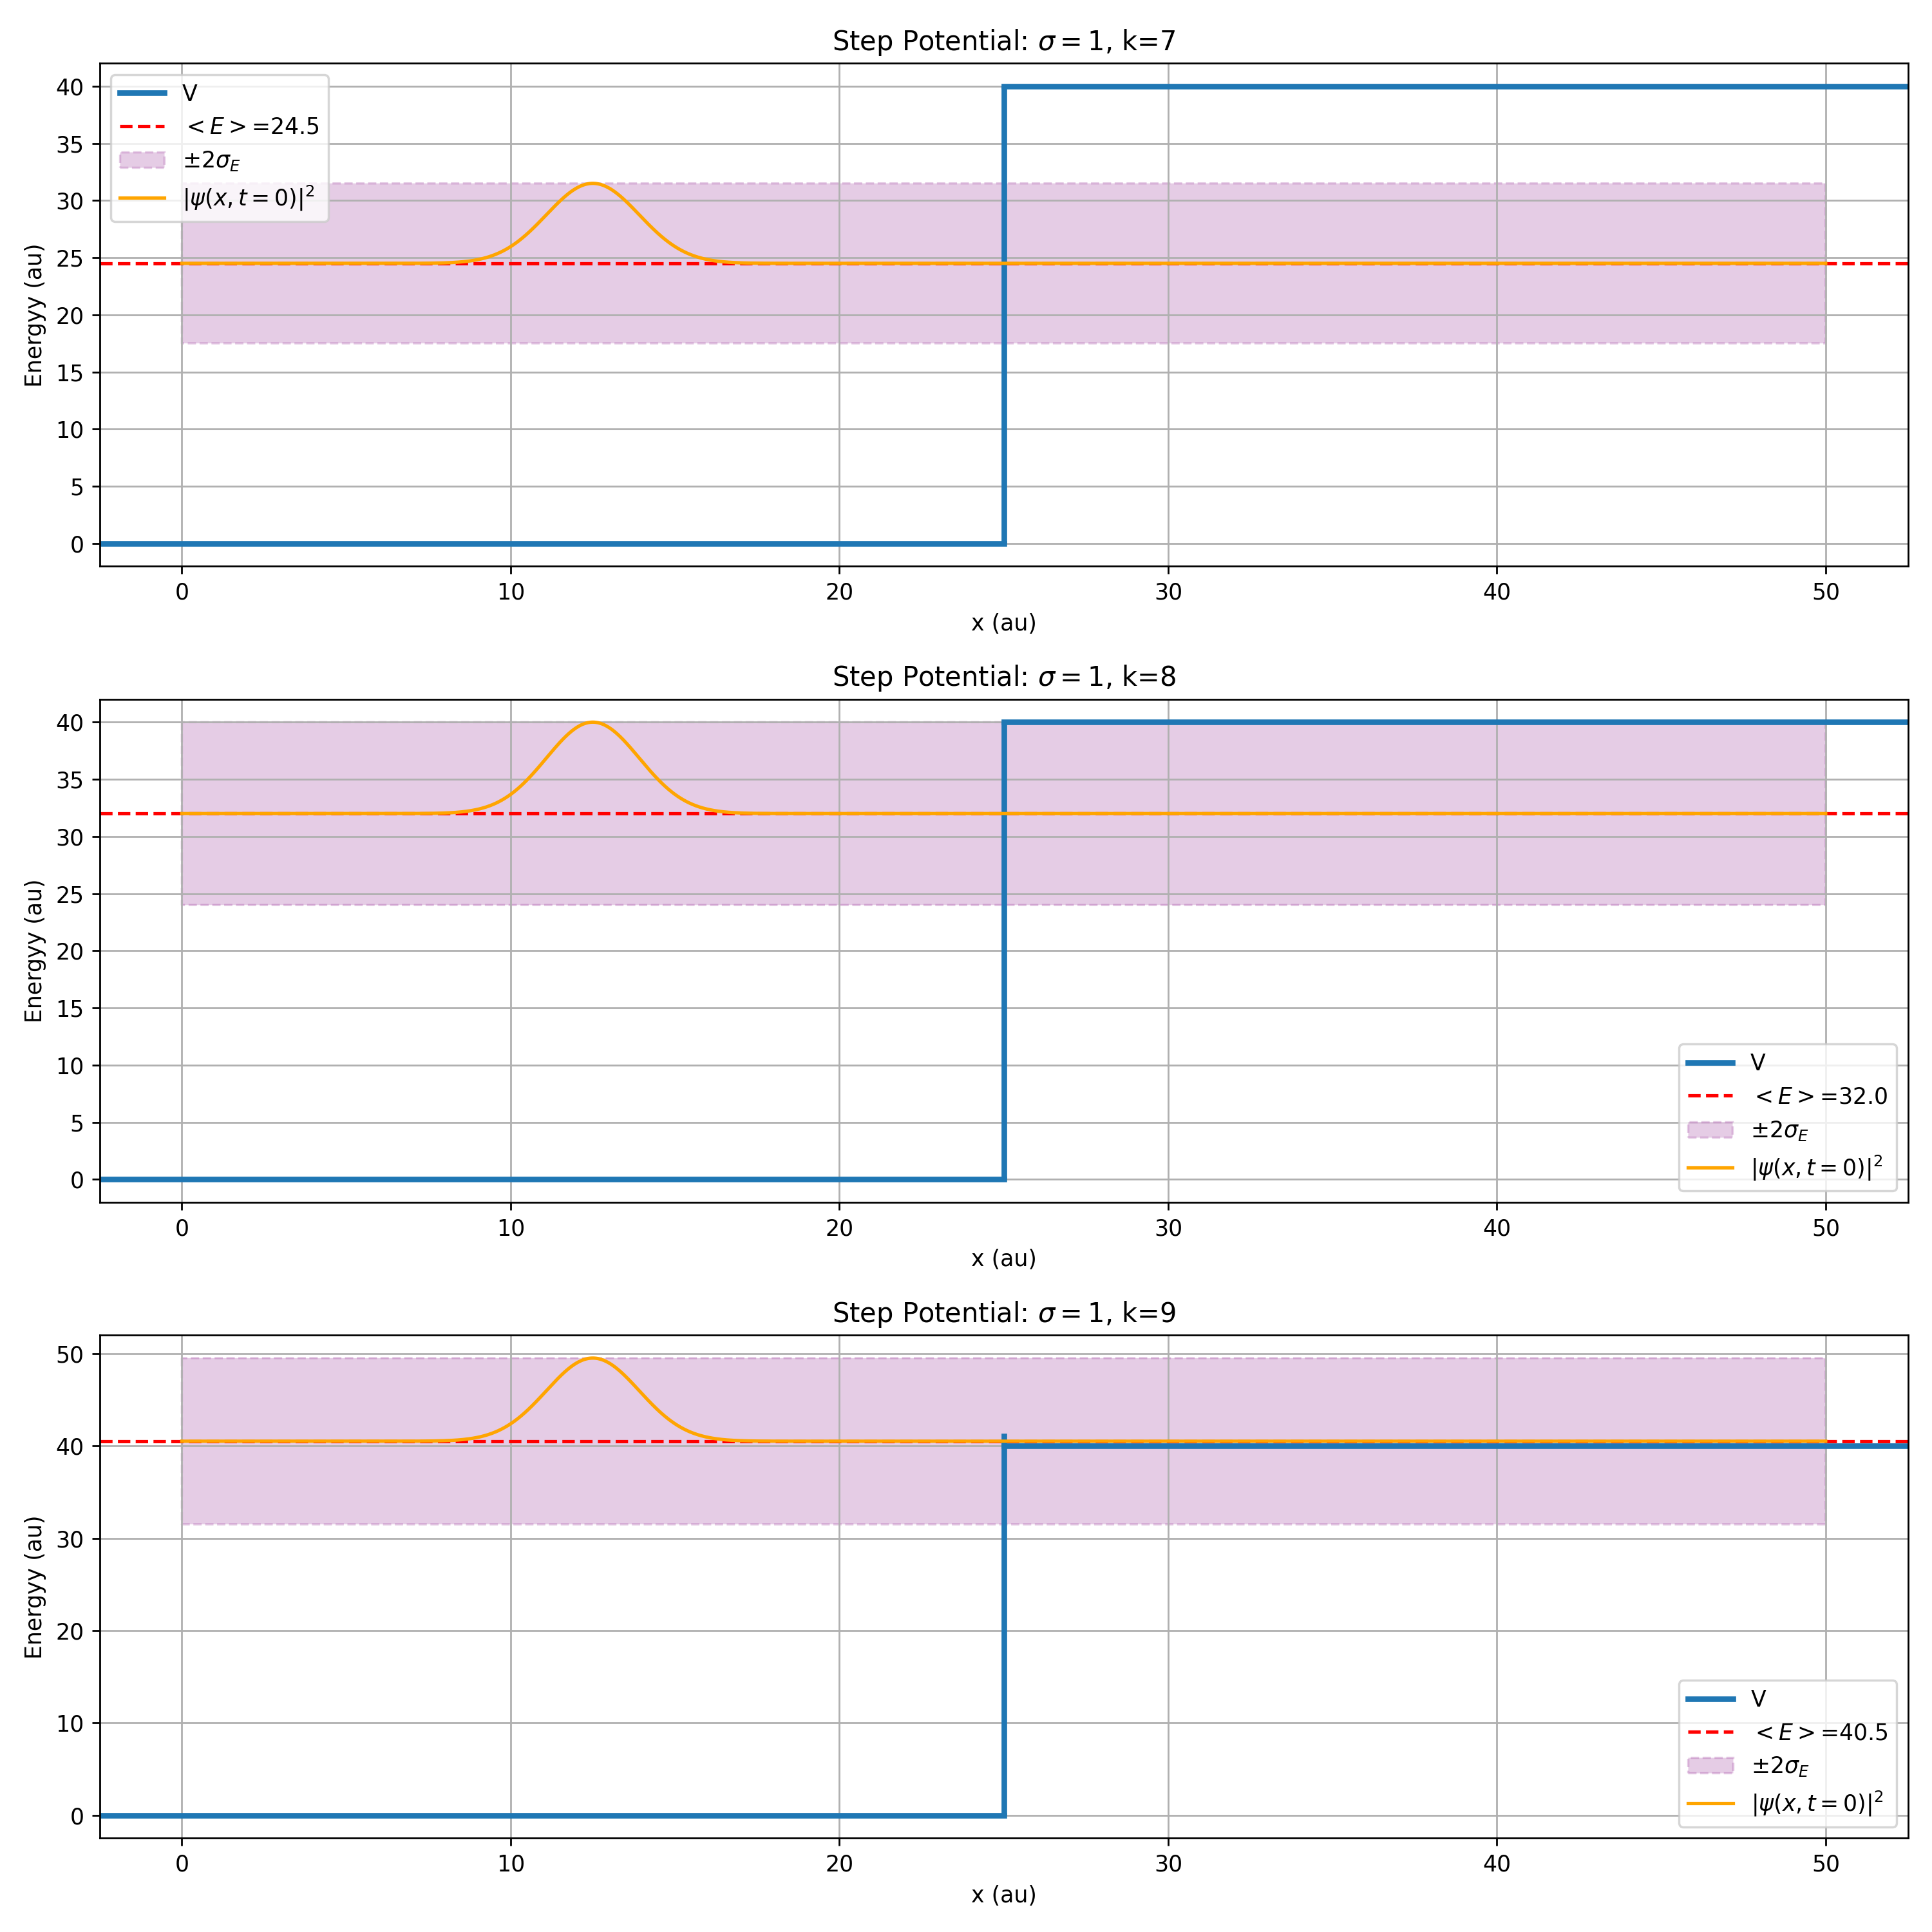

<IPython.core.display.Javascript object>


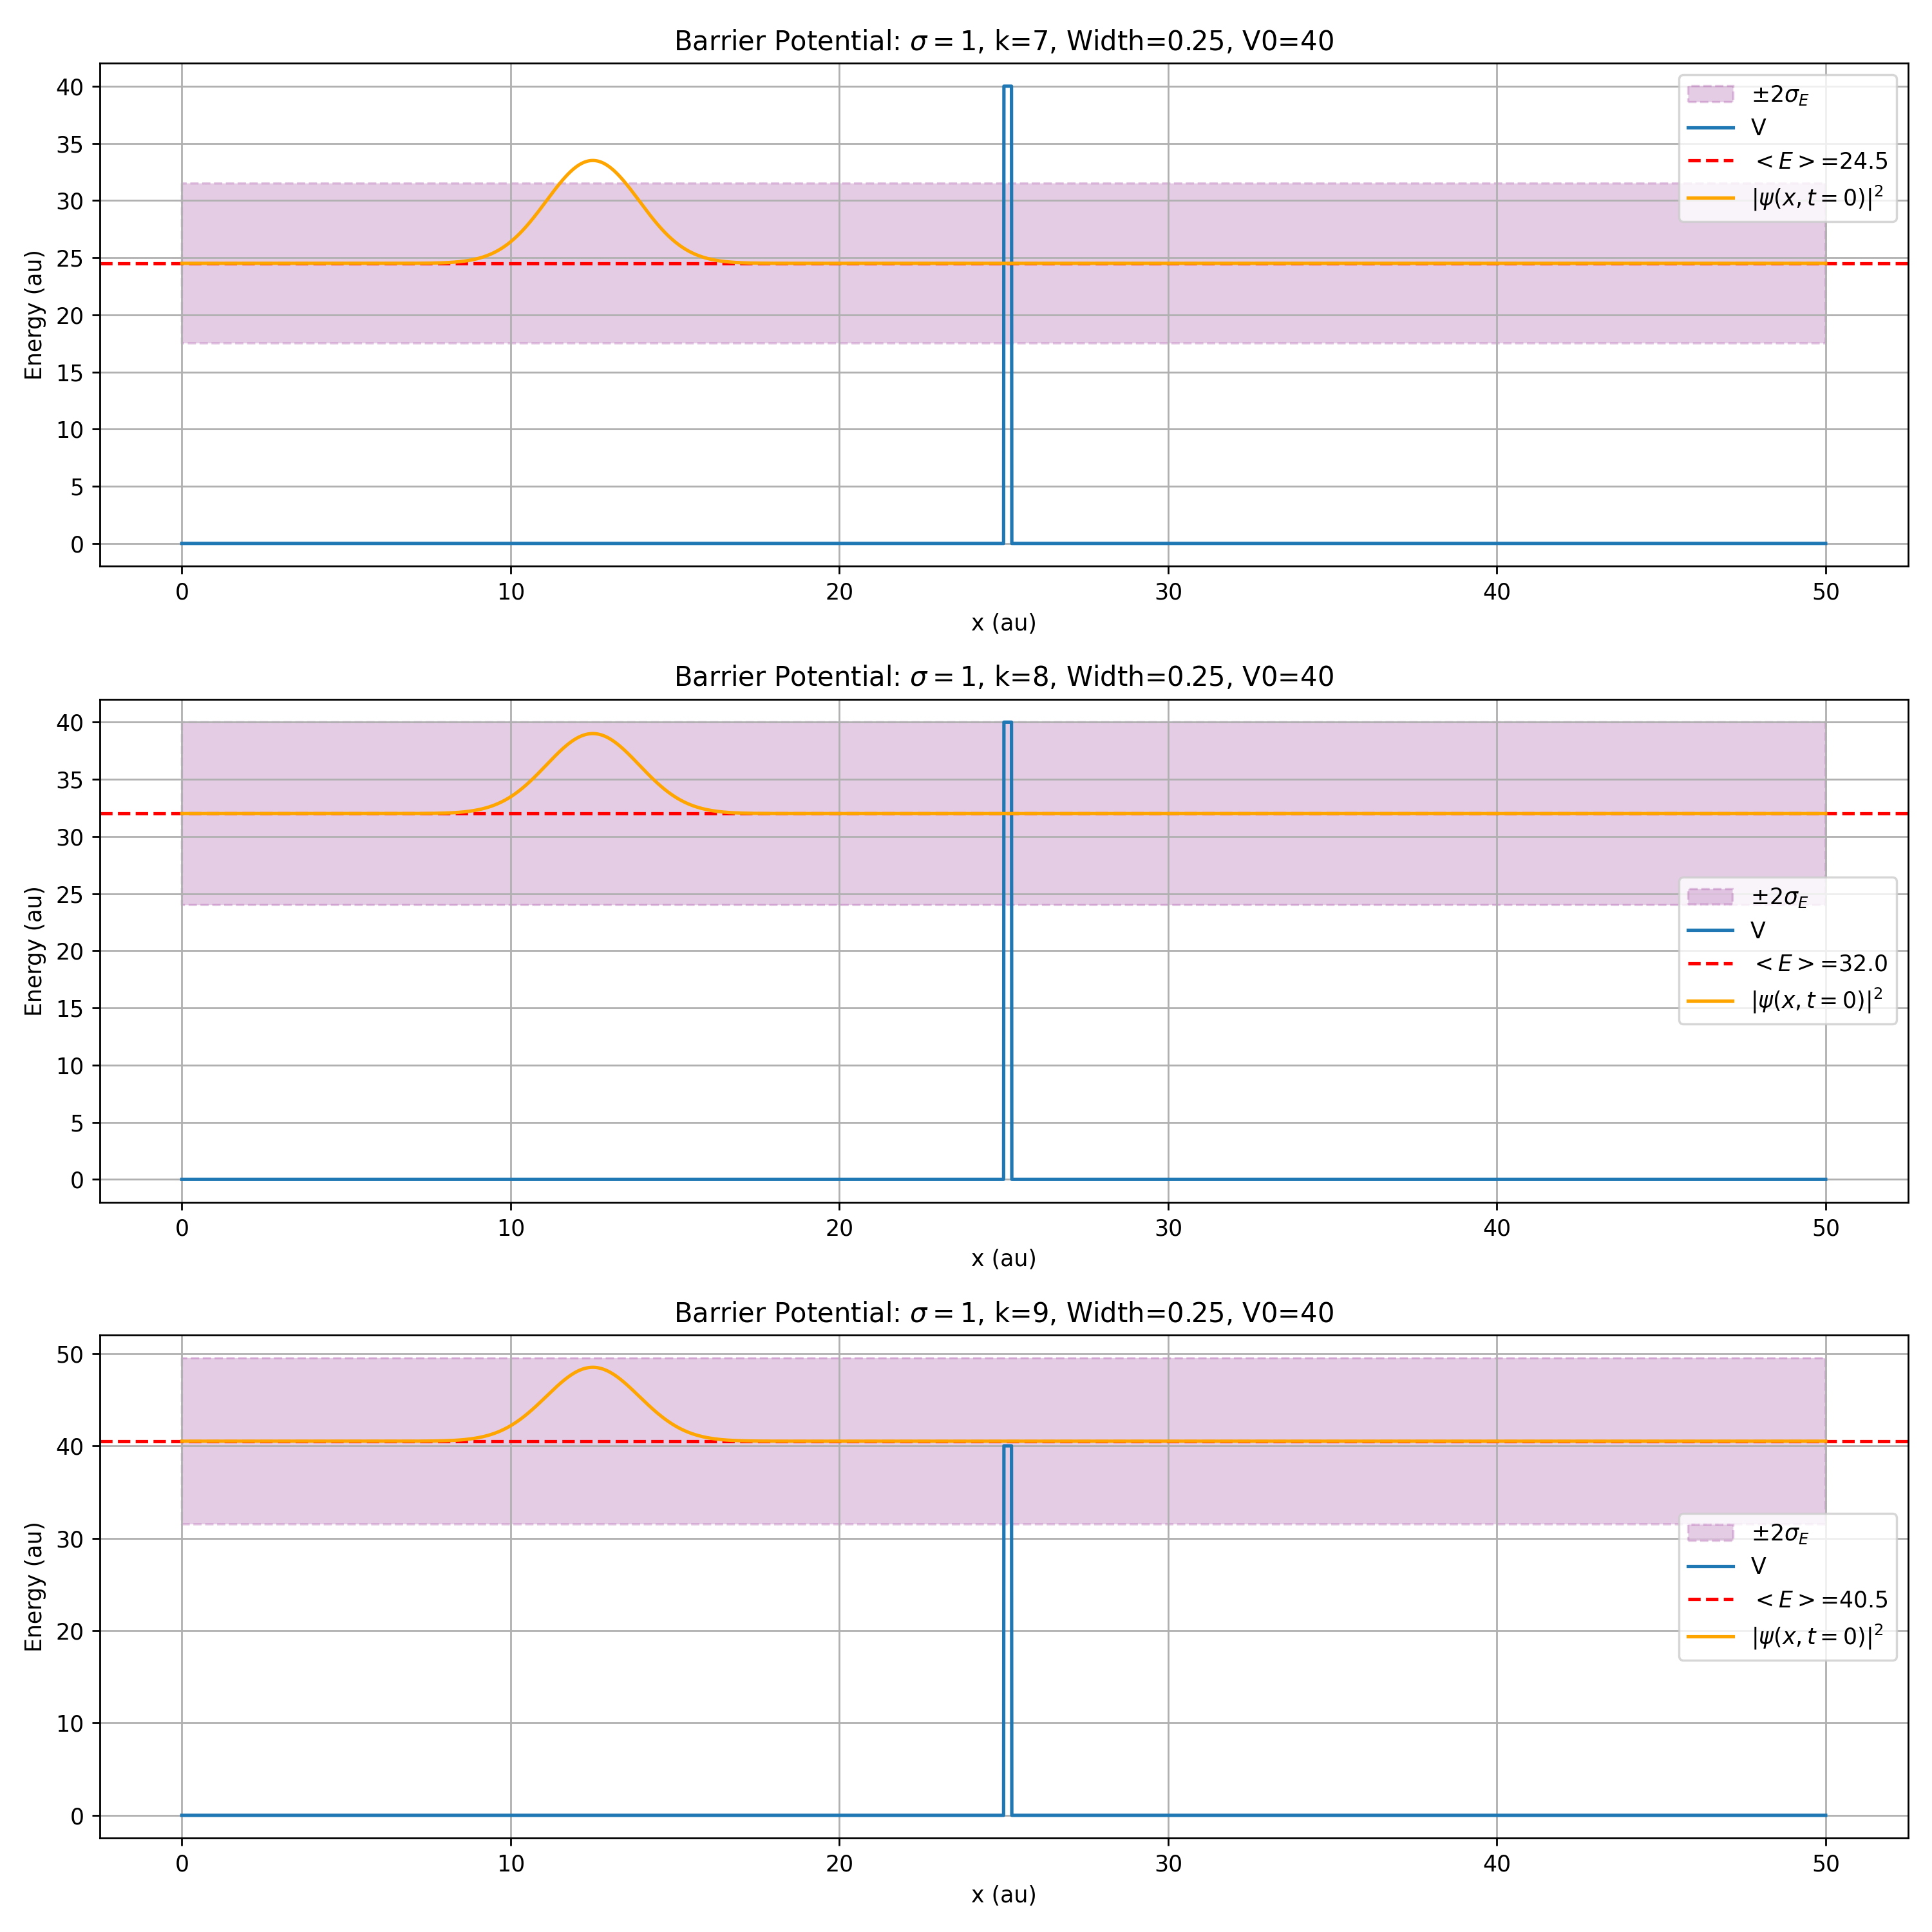

<IPython.core.display.Javascript object>


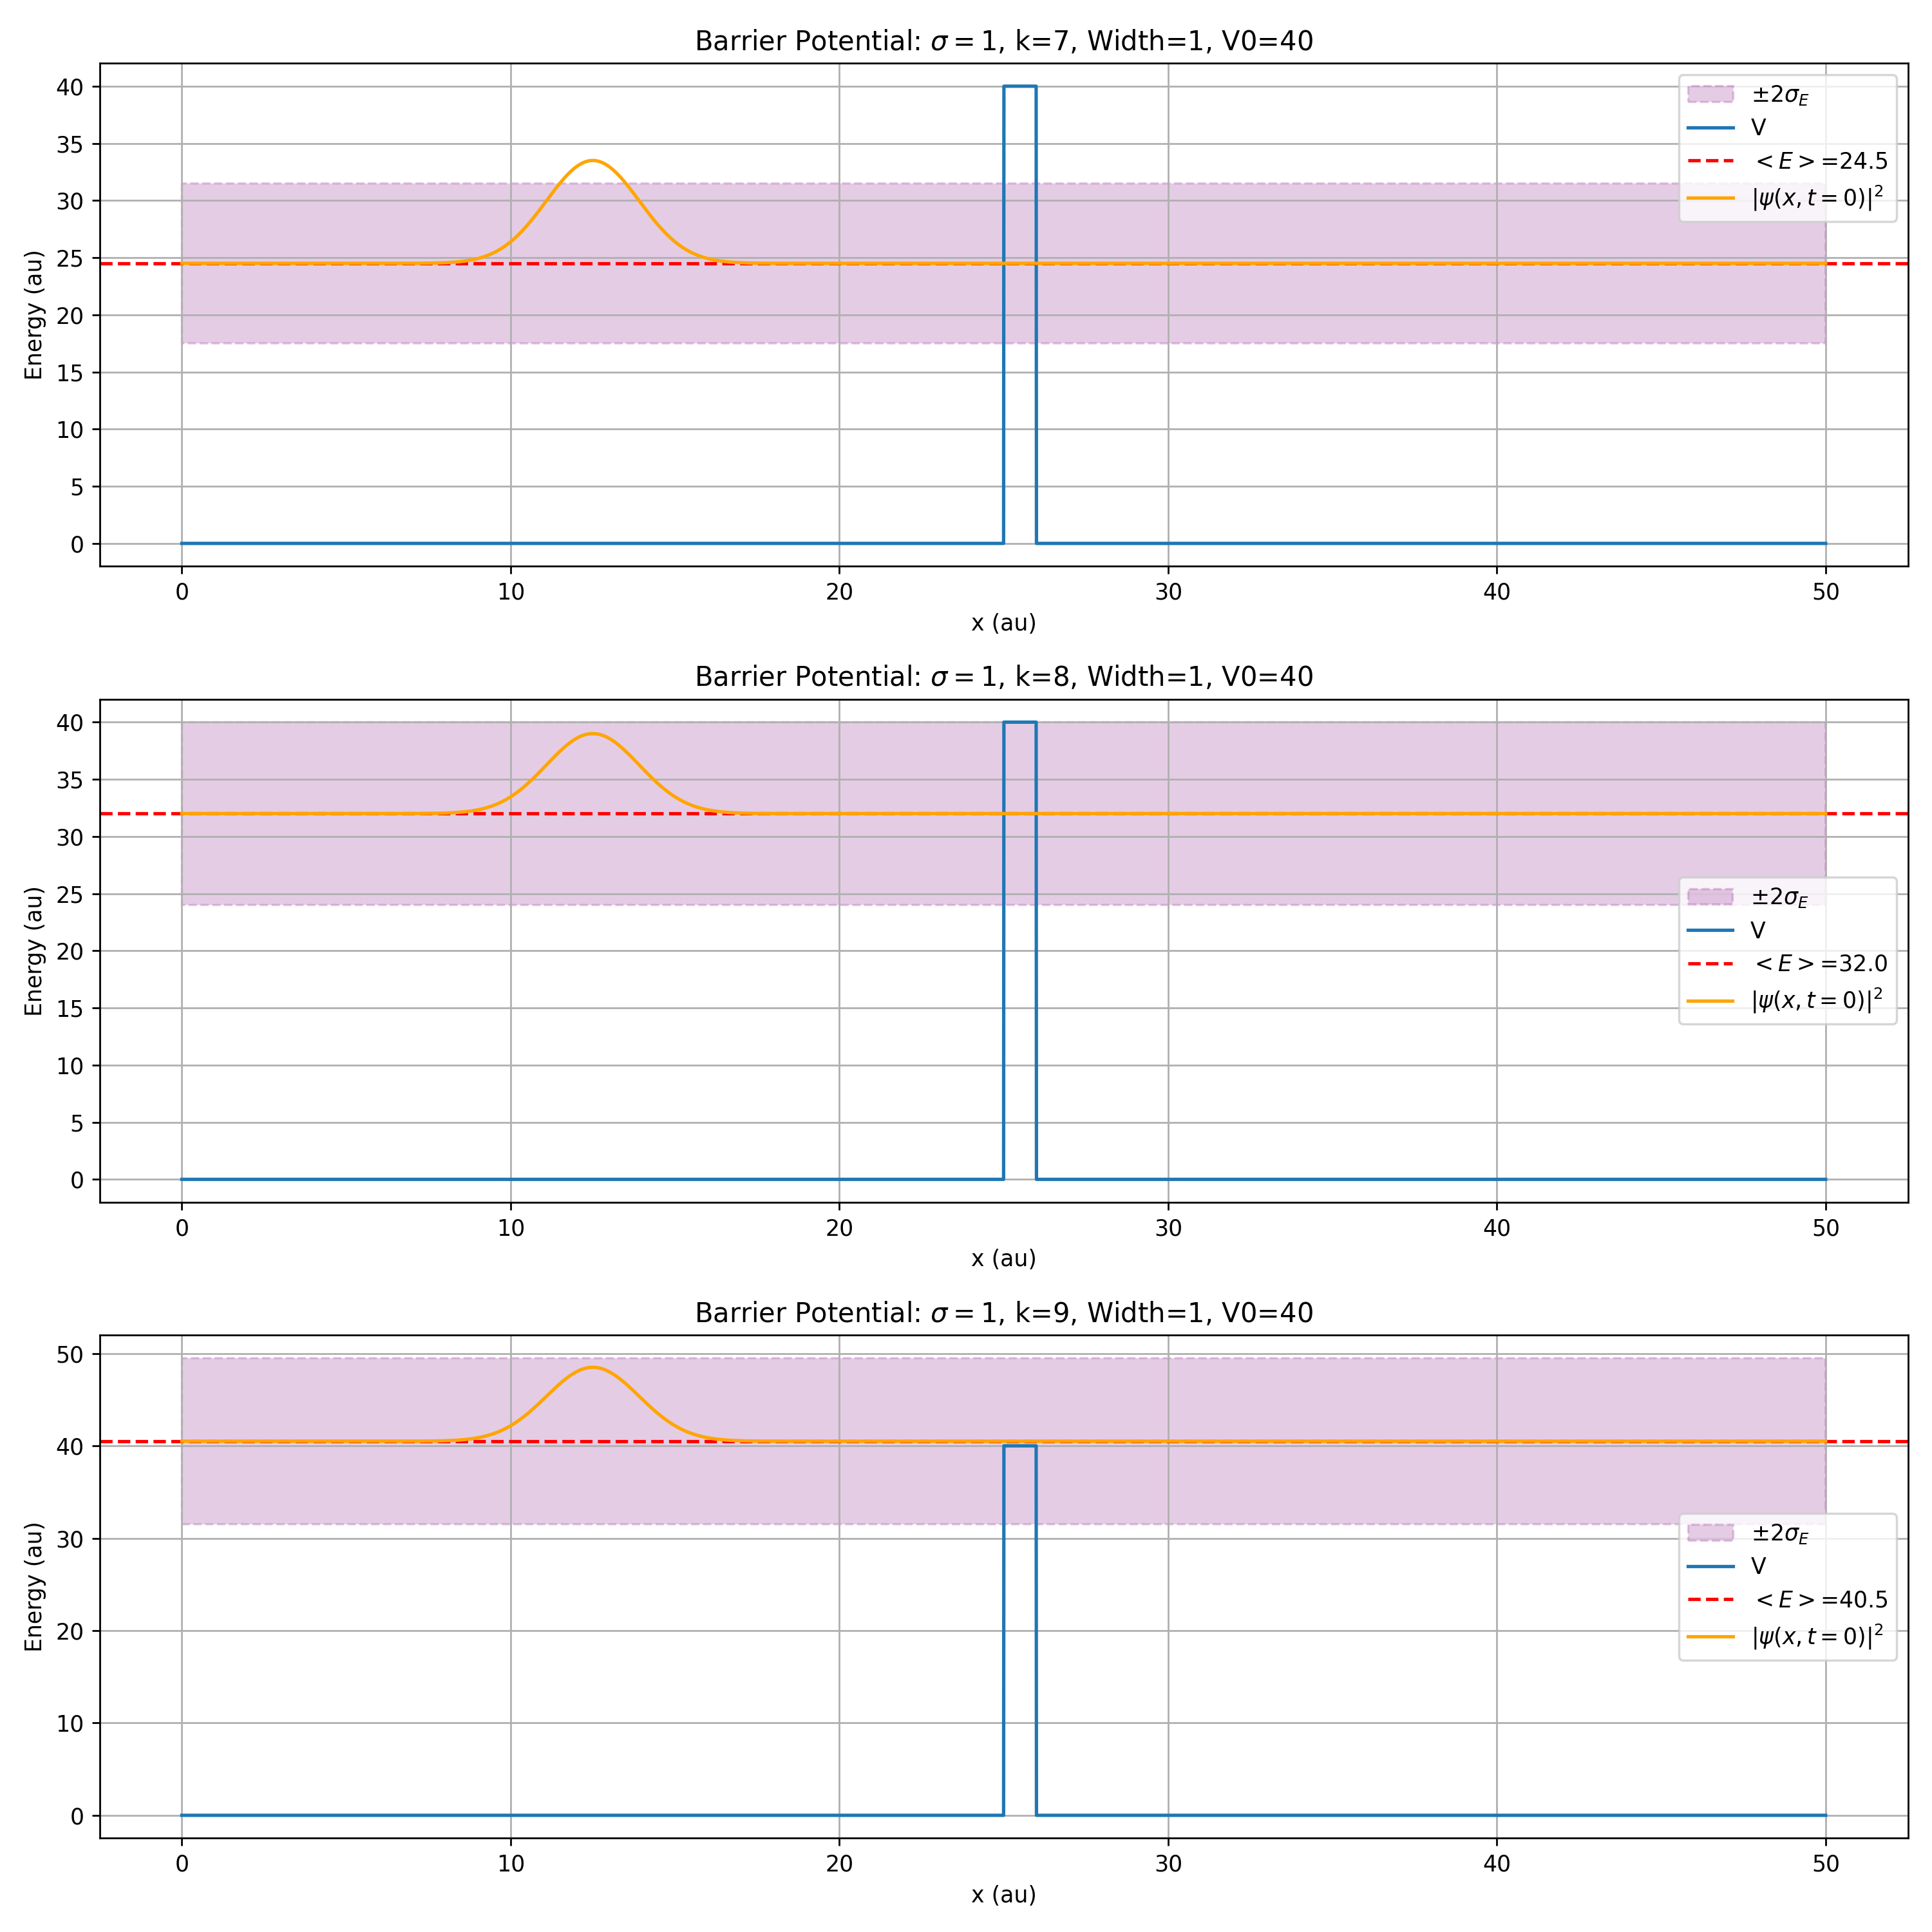

<IPython.core.display.Javascript object>


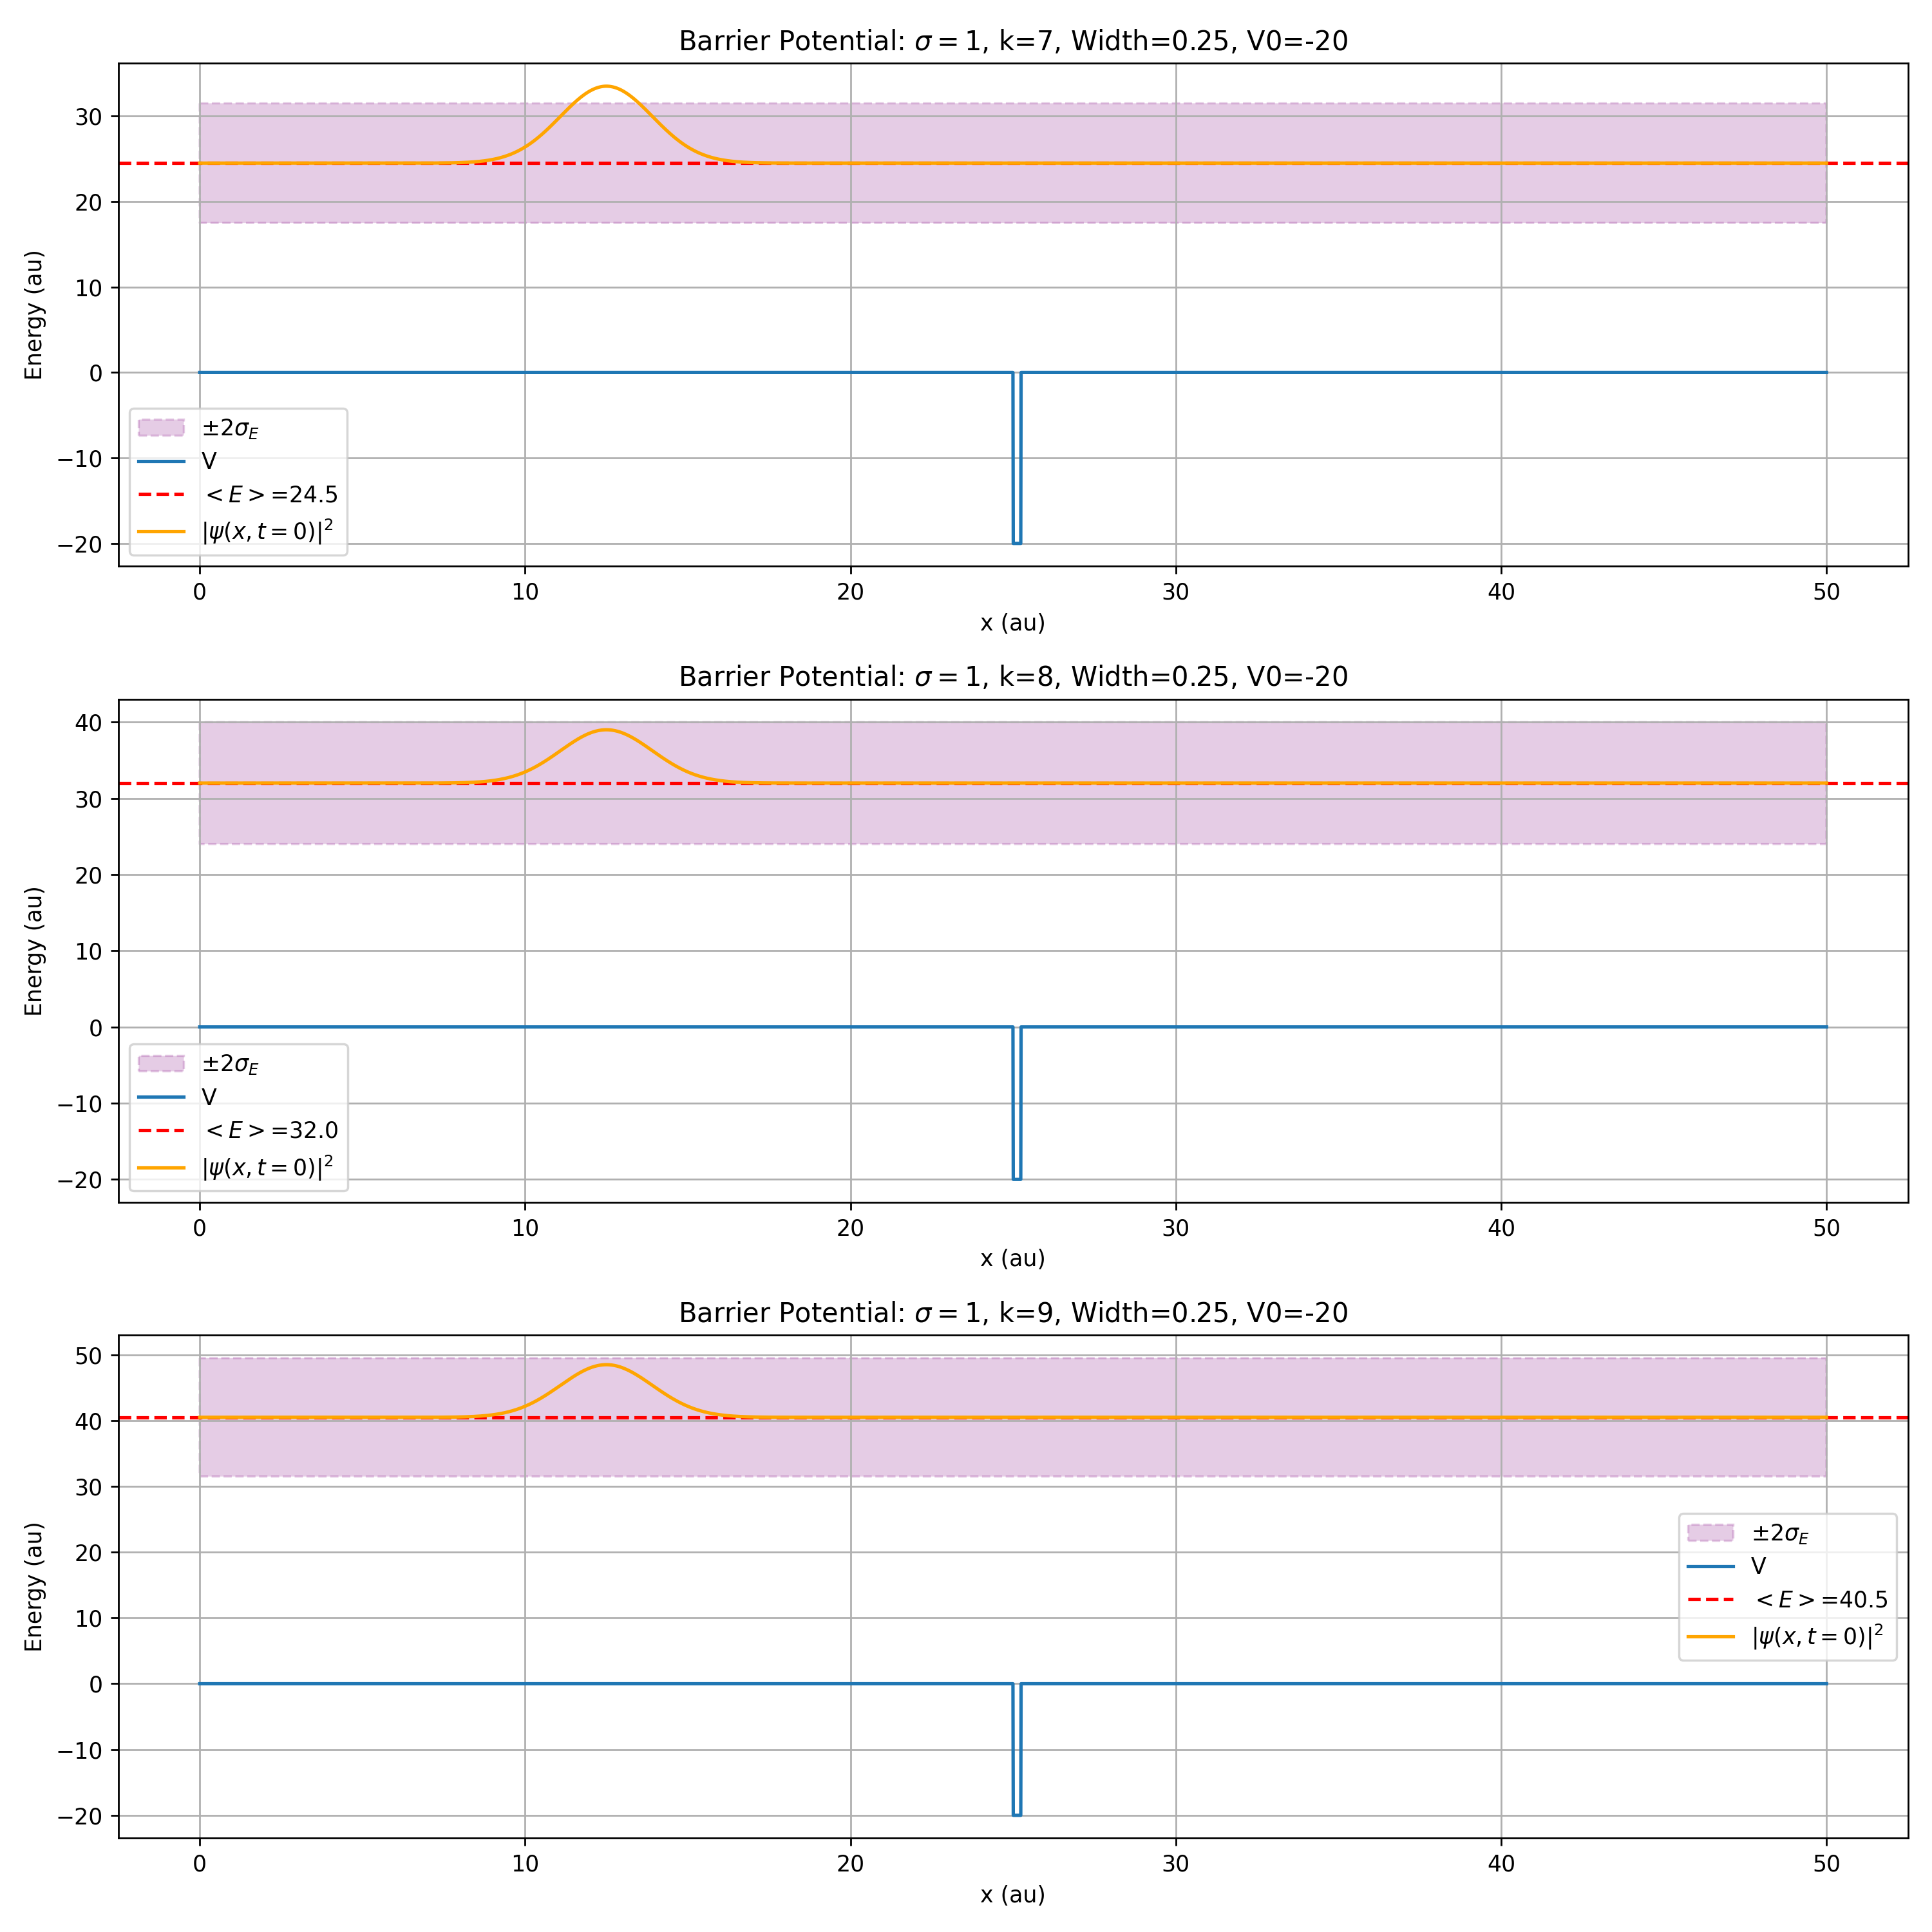

In [3]:
# Your code here...
ks=[7,8,9]

#step potential part
ϕ_step=step(N,40.0)
fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(0,len(ks)):
    energy,e_ul,e_ll,energy_sigma=energy_parameters(ks[i],σₓ)
    psi0=packet(σₓ,x,x0,ks[i])
    psi0_max=(np.abs(psi0)).max()
    scale=(e_ul-energy)/psi0_max
    ax[i].axhline(0.0,xmin=0.0,xmax=.5,linewidth=2.5)
    if ks[i]==9:
        ax[i].axvline(25.0,ymin=0.05,ymax=0.80,linewidth=2.5)
    else:
        ax[i].axvline(25.0,ymin=0.05,ymax=0.95,linewidth=2.5)
    ax[i].axhline(40.0,xmin=.5,xmax=1.0,linewidth=2.5,label='V')
    ax[i].axhline(energy,xmin=0,xmax=1.0,color='red',label=r'$<E>$='+f'{energy}',linestyle='--')
    ax[i].fill_between(x=x, y1=e_ll,y2=e_ul,color='purple',label=r'$\pm2\sigma_E$',linestyle='--',alpha=.2)
    ax[i].plot(x,abs(psi0)*scale+energy,color='orange',label=r'$|\psi(x,t=0)|^2$')
    ax[i].set_title(r'Step Potential: $\sigma=$'+ f'{σₓ}, k={ks[i]}')
    ax[i].legend()
    ax[i].set_xlabel('x (au)')
    ax[i].set_ylabel('Energyy (au)')
    ax[i].grid('--')
    plt.tight_layout()

    
## barrier potential part 
experiment=[(.25,40),(1,40),(.25,-20)]

for w,v in experiment:
    fig, ax = plt.subplots(3,1,figsize=(12,12))
    for i in range(0,len(ks)) :
        ϕ_barrier=barrier(N,v,x,dx,w)
        ϕ_barrier=[ϕ_barrier[i][i] for i in range(0,N)]
        psi0=packet(σₓ,x,x0,ks[i])
        psi0_max=(np.abs(psi0)).max()
        scale=(e_ul-energy)/psi0_max
        energy,e_ul,e_ll,energy_sigma=energy_parameters(ks[i],σₓ)  
        ax[i].fill_between(x=x, y1=e_ll,y2=e_ul,color='purple',label=r'$\pm2\sigma_E$',linestyle='--',alpha=.2)
        ax[i].plot(x,ϕ_barrier,label='V')
        ax[i].axhline(energy,xmin=0,xmax=1.0,color='red',label=r'$<E>$='+f'{energy}',linestyle='--')
        ax[i].plot(x,abs(psi0)*scale+energy,color='orange',label=r'$|\psi(x,t=0)|^2$')
        ax[i].set_title(r'Barrier Potential: $\sigma=$'+ f'{σₓ}, k={ks[i]}, Width={w}, V0={v}')
        ax[i].legend()
        ax[i].set_xlabel('x (au)')
        ax[i].set_ylabel('Energy (au)')
        ax[i].grid('--')
        plt.tight_layout()


__________________________________________________________________________________________
Part 3 (9 points)

- write the code to solve the TDSE to get the wave-function vs t given any of the conditions above. 
- make an animation of the wave-function based on the solution
- try it on one or more of the cases above




In [4]:
# # Your code here...
# laplacian= (np.diag(-2.0*np.ones(N))+np.diag(np.ones(N-1),1)+ \
#     np.diag(np.ones(N-1),-1))/dx**2

xmin=0
xmax=50

laplacian=sparse.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / dx**2

def ψₜ(t, ψ,V):
    return -1j*(hbar/(2*m)*laplacian.dot(ψ)+V/hbar*ψ)

V=barrier(N,40,x,dx,.25)
V=np.array([V[i,i] for i in range(0,N)])
k0=7
step=N//2
ψ=packet(σₓ,x,x0,k0)

print("start...")
sol=solve_ivp(ψₜ,t_span=[t0,tf],y0=ψ,t_eval=t,method="RK23", args=(V,))
print("success!")

start...
success!


<IPython.core.display.Javascript object>


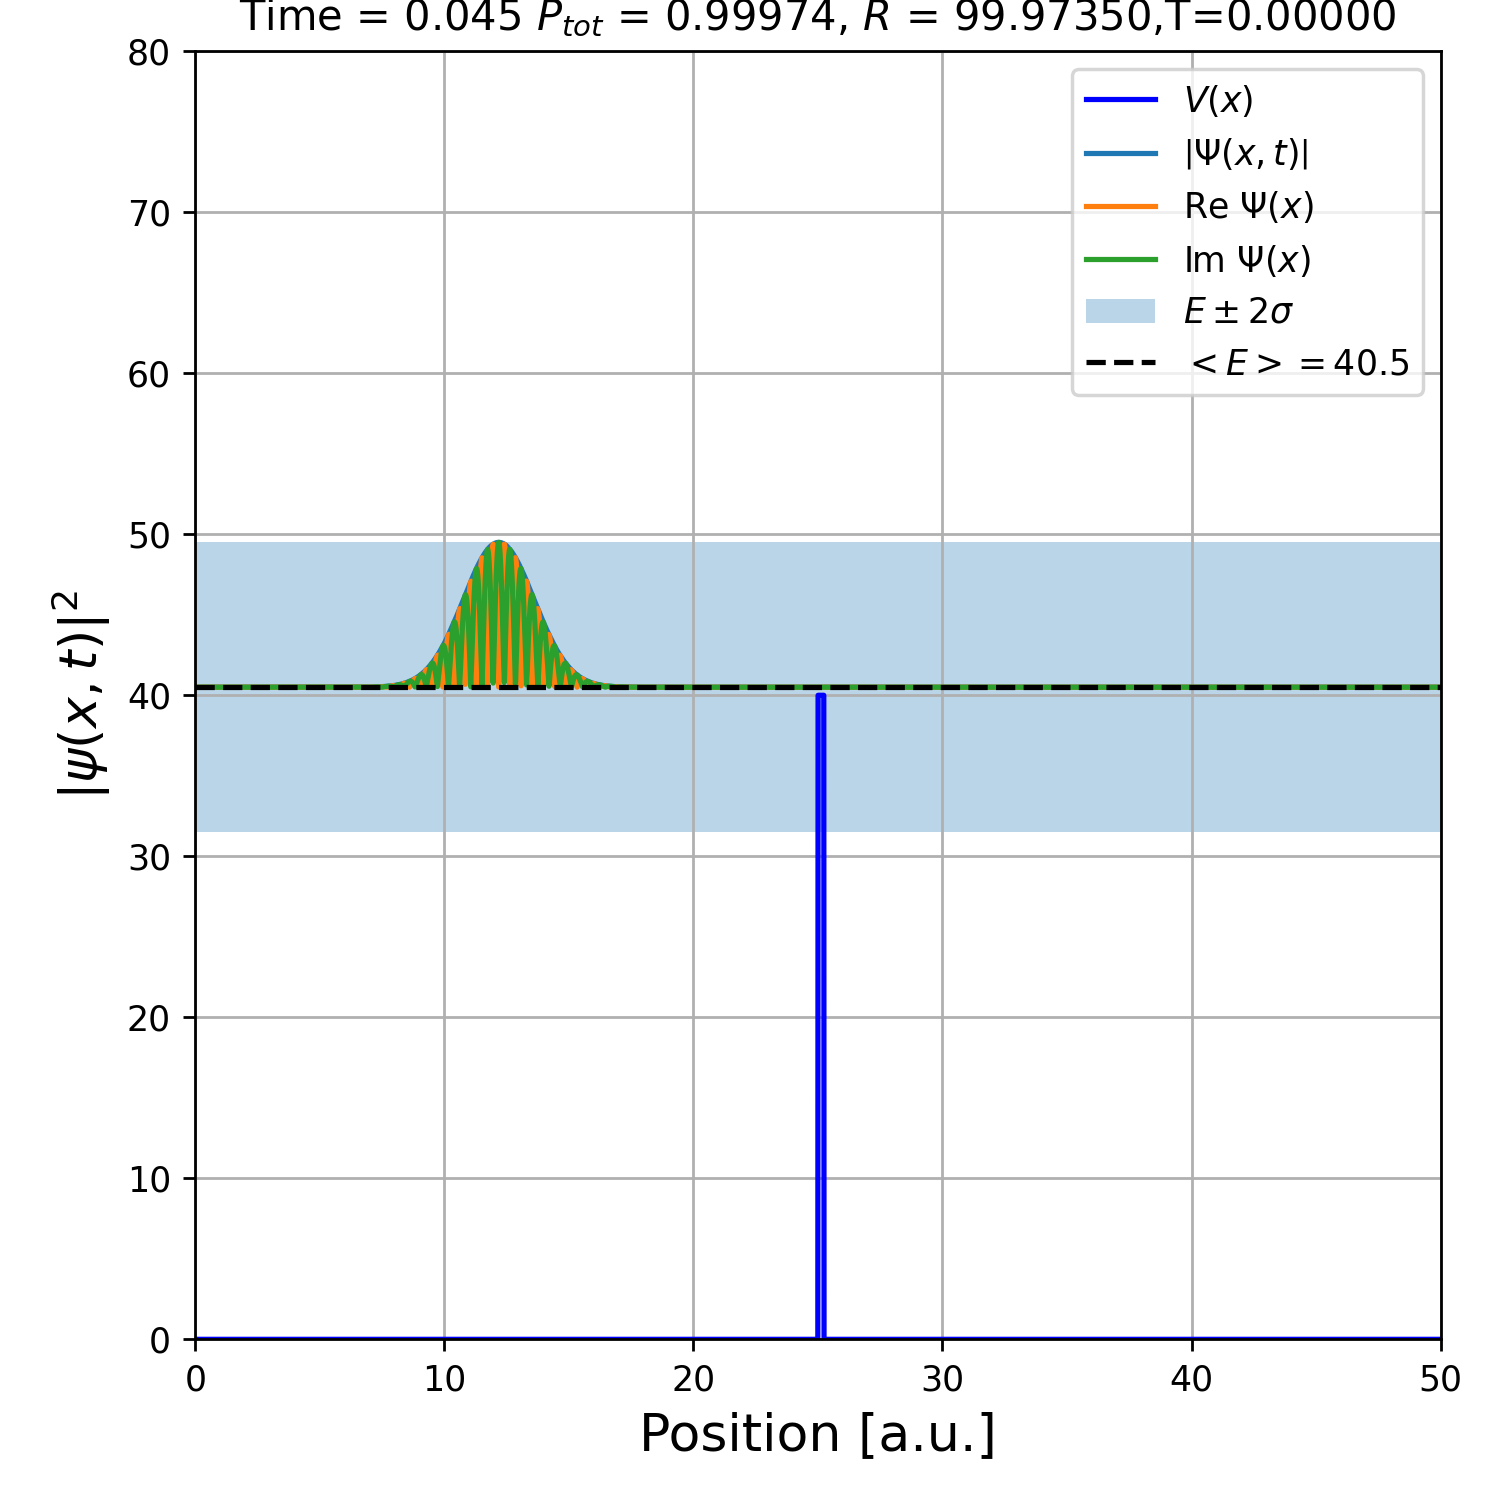

In [5]:
inte=np.empty(t.size)
inte_l=np.empty(t.size)
inte_r=np.empty(t.size)

for j in range(0,t.size):
    inte[j]=np.sum(np.abs(sol.y[:,j])**2)*dx
    inte_l[j]=np.sum(np.abs(sol.y[:step:,j])**2)*dx
    inte_r[j]=np.sum(np.abs(sol.y[step::,j])**2)*dx
    
fig=plt.figure(figsize=(6,6))
fig.clf()
ax1=plt.subplot(1,1,1)
psi0_max=(np.abs(psi0)).max()
scale=(e_ul-energy)/psi0_max
ax1.set_xlim(0,xmax)
ax1.set_ylim(0,80)
ax1.set_xlabel('Position [a.u.]', fontsize=15)
ax1.set_ylabel(r'$|\psi(x,t)|^2$', fontsize=15)
title=ax1.set_title('')
ax1.plot(x,V,color='blue',label=r'$V(x)$')
line1,=ax1.plot([],[],label=r'$\left| \Psi(x,t)\right|$')
line2,=ax1.plot([],[],label=r'Re $\Psi(x)$')
line3,=ax1.plot([],[],label=r'Im $\Psi(x)$')
plt.fill_between([x.min(),x.max()],[e_ll,e_ll],[e_ul,e_ul],alpha=.3,label=r'$E\pm 2 \sigma$')
ax1.plot([x.min(),x.max()],[energy,energy],'k--',label='$<E>=${:g}'.format(energy))
ax1.legend()

def init():
    line1.set_data([],[])
    line2.set_data([],[])
    line3.set_data([],[])
    return line1,line2,line3,

def animate(i):
    line1.set_data(x,energy+scale*np.abs(sol.y[:,i]))
    line2.set_data(x,energy+scale*np.abs(sol.y[:,i].real))
    line3.set_data(x,energy+scale*np.abs(sol.y[:,i].imag))
    integral = np.sum(np.abs(sol.y[:,i])**2)*dx
    left=np.sum(np.abs(sol.y[:N//2,i])**2)
    right=np.sum(np.abs(sol.y[N//2:,i])**2)
    #title.set_text('Time = {0:1.3f}'.format(sol.t[i]))
    title.set_text(r'Time = {:1.3f} $P_{{tot}}$ = {:1.5f}, $R$ = {:1.5f},T={:1.5f}'.format(sol.t[i],integral,left,right))
    return line1,line2,line3,

anim=animation.FuncAnimation(fig,animate,init_func=init,frames=len(sol.t),interval=50, blit=True)
plt.grid('--')
plt.tight_layout()
plt.show()

Part 4a (1 point)

- for case 2a) above run your script for the 3 $k_0$ and see what is happening
- calcuate the 'transmission' and 'reflection' for each


_______________________________________________________________________
Observations


________________________________________________________________________

Part 4b (1 point)

- for case 2b) above run your script for the 3 $k_0$ and see what is happening
- calcuate the 'transmission' and 'reflection' for each



_______________________________________________________________________
Observations


________________________________________________________________________

Part 4c (1 point)

- for case 2c) above run your script for the 3 $k_0$ and see what is happening
- calcuate the 'transmission' and 'reflection' for each




_______________________________________________________________________
Observations


________________________________________________________________________

Part 4d (1 point)

- for case 2d) above run your script for the 3 $k_0$ and see what is happening
- calcuate the 'transmission' and 'reflection' for each


________________________________________________
Observations


______________________________________________